In [5]:
from oo_sequence_ga import GA

from translation import SequenceGAEncoder, FJSSPInstancesTranslator
from evaluation import Makespan
from visualization import visualize_schedule, visualizer, visualizer_for_schedule
from model import Order, ProductionEnvironment
import time
import os
import inspect

In [6]:
def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

def run_experiment(source, instance, parameters : dict):
    production_environment = FJSSPInstancesTranslator().translate(source, instance)
    orders = generate_one_order_per_recipe(production_environment)
    production_environment.orders = orders
    workstations_per_operation, base_durations, job_operations = SequenceGAEncoder().encode(production_environment, orders)
    ga = GA(job_operations, workstations_per_operation, base_durations)
    population_size = parameters['population_size'] if 'population_size' in parameters else 100
    offspring_amount = parameters['offspring_amount'] if 'offspring_amount' in parameters else population_size
    max_generations = parameters['max_generations'] if 'max_generations' in parameters else None
    run_for = parameters['time_limit'] if 'time_limit' in parameters else None
    stop_at = parameters['target_fitness'] if 'target_fitness' in parameters else None
    random_initialization = parameters['random_initialization'] if 'random_initialization' in parameters else False
    elitism = parameters['elitism'] if 'elitism' in parameters else 0
    allow_duplicate_parents = parameters['duplicate_parents'] if 'duplicate_parents' in parameters else False
    pruning = parameters['pruning'] if 'pruning' in parameters else False
    fill_gaps = parameters['fill_gaps'] if 'fill_gaps' in parameters else False
    adjust_individuals = parameters['adjust_individuals'] if 'adjust_individuals' in parameters else False
    adjust_parameters = parameters['adjust_mutation'] if 'adjust_mutation' in parameters else False
    update_interval = parameters['mutation_update_interval'] if adjust_parameters else 0
    p_increase_rate = parameters['mutation_increase_rate'] if adjust_parameters else 0
    max_p = parameters['max_mutation_rate'] if adjust_parameters else 0
    restart_at_max_p = parameters['restart_at_max_mutation_rate'] if adjust_parameters else False
    avoid_local_mins = parameters['avoid_local_mins'] if adjust_parameters else False
    local_min_distance = parameters['local_min_distance'] if avoid_local_mins else 0.0
    sequence_mutation = parameters['sequence_mutation'] if 'sequence_mutation' in parameters else 'mix'
    selection = parameters['selection'] if 'selection' in parameters else 'tournament'
    tournament_size = parameters['tournament_size'] if selection == 'tournament' else 0
    random_individual_per_generation_amount = parameters['random_individuals'] if 'random_individuals' in parameters else 0
    output_interval = parameters['output_interval'] if 'output_interval' in parameters else 1000
    start_time = time.time()
    result, history = ga.run(population_size, offspring_amount, max_generations, run_for, stop_at, None, selection, tournament_size, adjust_parameters, update_interval=update_interval, p_increase_rate=p_increase_rate, max_p=max_p, restart_at_max_p=restart_at_max_p, avoid_local_mins=avoid_local_mins, local_min_distance=local_min_distance, elitism=elitism, sequence_mutation=sequence_mutation, pruning=pruning, fill_gaps=fill_gaps, adjust_optimized_individuals=adjust_individuals, random_individuals=random_individual_per_generation_amount, allow_duplicate_parents=allow_duplicate_parents, random_initialization=random_initialization, output_interval=output_interval)
    run_time = time.time() - start_time
    schedule = SequenceGAEncoder().decode(result.sequence, result.workstations, None, result.durations, job_operations, production_environment, True, None)
    visualizer_for_schedule(schedule, job_operations)
    return result, run_time, ga.function_evaluations, ga.restarts, ga.generations

In [7]:
def run_and_visualize(source, instance, max_generation : int = 5000, time_limit : int = 600, target_fitness : float = None, output : bool = False, elitism : bool = True):
    parameters = {
        'population_size': 5,
        'offspring_amount': 20,
        'max_generations': max_generation,
        'time_limit': time_limit,
        'target_fitness': target_fitness,
        'elitism': 1 if elitism else None,
        'random_initialization': False,
        'duplicate_parents': False,
        'pruning': False,
        'fill_gaps': False,
        'adjust_individuals': True,
        'adjust_mutation': True,
        'mutation_update_interval': 100,
        'mutation_increase_rate': 1.1,
        'max_mutation_rate': 1.0,
        'restart_at_max_mutation_rate': True,
        'avoid_local_mins': True,
        'local_min_distance': 0.1,
        'sequence_mutation': 'mix',
        'selection': 'tournament', # 'tournament'
        'tournament_size': 2,
        'random_individuals': 0,
        'output_interval': 100 if output else 0
    }

    result, run_time, fevals, restarts, generations = run_experiment(source, instance, parameters)


Generation 0: Overall Best: 966, Current Best: 966, Generation Best: 966, Average Generation Fitness: 1137.8 - Current Runtime: 0.016999244689941406s, Function Evaluations: 5, Restarts: 0, Infeasible Solutions: 0
Generation 100: Overall Best: 610, Current Best: 610, Generation Best: 610, Average Generation Fitness: 610.0 - Current Runtime: 0.18603277206420898s, Function Evaluations: 2005, Restarts: 0, Infeasible Solutions: 0
Generation 200: Overall Best: 594, Current Best: 594, Generation Best: 594, Average Generation Fitness: 597.5 - Current Runtime: 0.5267274379730225s, Function Evaluations: 5490, Restarts: 1, Infeasible Solutions: 0
Generation 300: Overall Best: 573, Current Best: 573, Generation Best: 573, Average Generation Fitness: 855.7 - Current Runtime: 0.8999111652374268s, Function Evaluations: 9490, Restarts: 1, Infeasible Solutions: 0
Generation 400: Overall Best: 558, Current Best: 558, Generation Best: 558, Average Generation Fitness: 760.35 - Current Runtime: 1.881656408

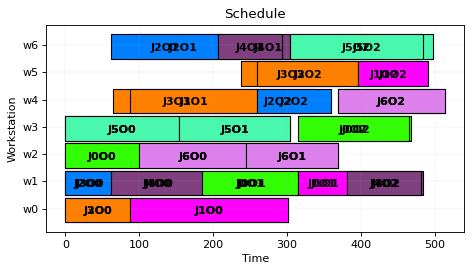

In [8]:
run_and_visualize('6_Fattahi', 15, None, None, 514, True, True)